# GRIDtools area weighted volume test - comparing different zonal methods of precipitation across a watershed

Perform the necessary imports, GRIDtools install of v0.0.7 may still require you to set up an environment with the necessary dependencies.

In [1]:
import pynhd
from pathlib import Path
import geopandas as gpd
import rasterio as rio
import pandas as pd
import xarray as xr
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import xvec
from chmdata.thredds import GridMet, BBox
import os
import GRIDtools as gt

In [2]:
#pckg_path = Path('C:/Users/CNB968/OneDrive - MT/GitHub/GRIDtools/src')
#os.chdir(pckg_path)
#import GRIDtools as gt
#from GRIDtools.zonal import calc_zonal_stats
#from GRIDtools.utils import RasterClass
#from GRIDtools.zonal import sample_raster_points

Let's create a Geopandas GeoDataFrame of a couple of points within the Lolo Watershed in western Montana. Also, a "name" column is added to provide a unique ID to each point.

In [2]:
# Create geopandas.GeoDataFrame of some points we want to delineate upstream catchments for
pour_pnt = gpd.GeoDataFrame(
    {
        "name": ["Lolo_Catchment", "Bear_Creek_Catchment"]
    },
    geometry=[Point(-114.133170, 46.748808),
              Point(-114.324042, 46.766956)],
    crs=4326
)

Use GRIDtools delineate watershed function with the GeoDataFrame as input to get the drainage areas upstream of the points.

In [3]:
# Use delineate_watershed function to get polygon's of the contributing drainage area upstream of each point in GeoDataFrame
result = gt.delineate_watershed(pour_pnt)

In [4]:
# view table
result

,req_idx,catchmentID,geometry,Area_sqKm,name,direction,upstream,gnis_name,comid,reachcode,intersection_point
0,1,NaN,"POLYGON ((-114.35519 46.82845, -114.35519 46.8...",28.379194,Bear_Creek_Catchment,up,True,Bear Creek,24321310,17010205001011,"[-114.32473199573879, 46.76647114978662]"
1,0,NaN,"POLYGON ((-114.65629 46.739, -114.65629 46.739...",653.531430,Lolo_Catchment,up,True,Lolo Creek,24319270,17010205000088,"[-114.12979611165137, 46.747740712007136]"


You can see that the result returns another Geopandas GeoDataFrame that contains POLYGON geometries for the upstream drainage areas. The original uniqe ID (in this case the "name" column) is retained and additional attributes are returned including the Area in square Kilometers, the GNIS_name of the NHD segment that each point intersected, as well as its comid and reachcode. The catchmentID is NaN because it is a custom delineation so it does not conform to a known HUC. The intersection point is the flow direction trace intersection point from the original input point and where it intersected an NHD stream segment.

We can use Geopandas to visualize the output POLYGONs.

<Axes: >

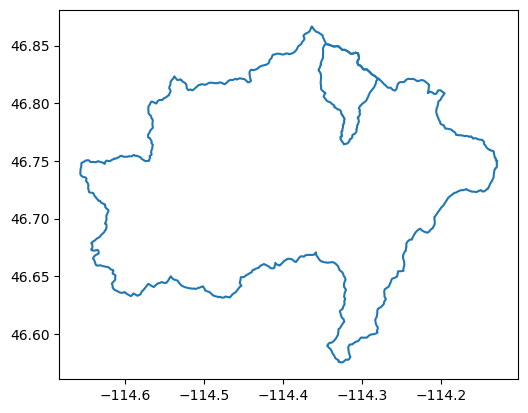

In [5]:
# plot watershed boundaries
result.boundary.plot()

## Get GridMET Precipitation Data

Next we will use DNRC's chmdata package to get some precipitation data for the delineated watersheds.

In [6]:
# Use chmdata to get GridMET precipitation data for the area of interest
# Create the bbox
bnds = result.total_bounds
bbox = BBox(bnds[0]-0.2, bnds[2]+0.2, bnds[3]+0.2, bnds[1]-0.2)
gmet = GridMet(variable='pr', start='2016-01-01', end='2024-12-01', bbox=bbox)
prcp = gmet.subset_nc(return_array=True)
# These lines of code fix some problems with GridMET's CRS attributes
#   FIX in chmdata so correct attributes are returned
#geotrans = prcp.crs.GeoTransform.split(' ')
#new_geotran = ' '.join([geotrans[0], geotrans[1], geotrans[2], geotrans[4], '0.0', geotrans[5]])
#prcp['crs'] = prcp.crs.assign_attrs(crs_wkt=prcp.crs.attrs['spatial_ref'], GeoTransform=new_geotran)
# write the coordinate reference system
prcp = prcp.rio.write_crs(prcp.rio.crs)

This returns an xarray Dataset for the given bounding box. We can use Matplotlib to visulaize the grided data (in this case the total sum for the period requested 2016-01-01 to 2024-12-01).

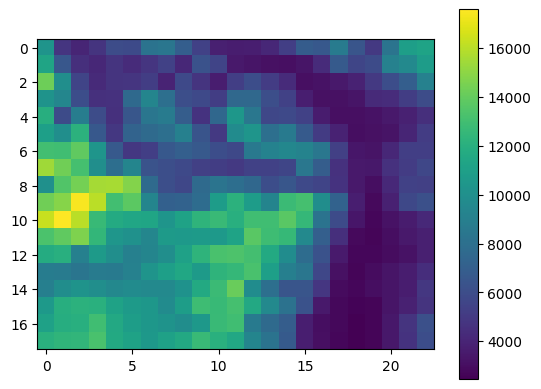

In [11]:
# view cumulative precip over the time period
plt.imshow(prcp.precipitation_amount.sum(dim='time'))
plt.colorbar()

### Compare GRIDtools grid_area_weighted_volume() function with exactextract output

Reproject the precipitation data and basin geometries to a projected crs for area calculation in zonal stats packages.

In [12]:
prcp_proj = prcp.rename({'lat': 'y', 'lon': 'x'})
prcp_proj = prcp_proj.rio.reproject(5071)

In [13]:
geom_proj = result.to_crs(5071)

<Axes: title={'center': 'crs = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

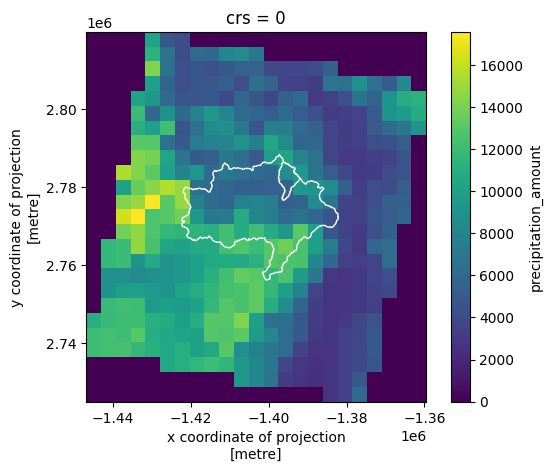

In [14]:
ax = plt.axes() 
prcp_proj.precipitation_amount.sum(dim='time').plot(ax=ax)
geom_proj.plot(ax=ax, facecolor='None', edgecolor='white')
#plt.colorbar()

In [15]:
prcp_proj_s = prcp_proj.copy()
prcp_proj_s['precipitation_amount'] = prcp_proj_s.precipitation_amount / 1000
prcp_proj_s.rio.set_crs(5071, inplace=True)

<xarray.Dataset> Size: 15MB
Dimensions:               (x: 23, y: 25, time: 3258)
Coordinates:
  * x                     (x) float64 184B -1.445e+06 -1.441e+06 ... -1.361e+06
  * y                     (y) float64 200B 2.818e+06 2.814e+06 ... 2.727e+06
  * time                  (time) datetime64[ns] 26kB 2016-01-01 ... 2024-12-01
    crs                   int64 8B 0
Data variables:
    precipitation_amount  (time, y, x) float64 15MB nan nan nan ... nan nan nan
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 February 2025
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

Zonal Stats using the rasterize method in xvec package for 'mean' and then multiplying one year's worth of precip by geometry area. Here we are only doing a comparison of the 1st geometry.

In [16]:
# based on rasterize using the xvec package
rastrz = prcp_proj_s.xvec.zonal_stats(geom_proj.loc[[0]].geometry, x_coords='x', y_coords='y', stats=['mean', 'count'], all_touched=True)

In [17]:
rvol = rastrz.precipitation_amount.sel(zonal_statistics='mean') * geom_proj.area[0]
print(f"{rvol.sel(time=slice('2016-01-01', '2016-12-31')).sum().values} m^3")

27035438.951444723 m^3


Zonal Stats using the GRIDtools zonal stats method, same as xvec procedure, get the mean for one year's worth of precip and multiply by area.

In [20]:
gtrastrz = gt.calc_zonal_stats(geom_proj.loc[[0]], prcp_proj_s, all_touched=True, output='pandas')

In [21]:
gtrastrz

precipitation_amount
FID time       stat                      
0   2016-01-01 mean              0.000000
    2016-01-02 mean              0.000000
    2016-01-03 mean              0.000000
    2016-01-04 mean              0.000000
    2016-01-05 mean              0.000000
...                                   ...
    2024-11-27 mean              0.000067
    2024-11-28 mean              0.000000
    2024-11-29 mean              0.000000
    2024-11-30 mean              0.000000
    2024-12-01 mean              0.000117

[3258 rows x 1 columns]

In [23]:
gtrstr_vol = gtrastrz.loc[(slice(None), slice('2016-01-01', '2016-12-31'), 'mean')] * geom_proj.area[0]
print(f"{gtrstr_vol['precipitation_amount'].sum()} m^3")

27035438.951444723 m^3


Zonal Stats using the exactextract package via xvec, this gets a true (or close) weighted volume by overlapped cell areas.

In [24]:
# exactextract algorithm used via the xvec package
exac = prcp_proj_s.xvec.zonal_stats(geom_proj.loc[[0]].geometry, x_coords='x', y_coords='y', stats="sum(coverage_weight=area_cartesian)", method='exactextract')

c:\Users\CNB968\.conda\envs\wmbflow\lib\site-packages\exactextract\exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(


In [25]:
evol = exac.precipitation_amount.sel(time=slice('2016-01-01', '2016-12-31'))
print(f'{evol.sum().values} m^3')

25166916.33543125 m^3


Zonal Stats using exactextract package directly with a weighting raster of cell areas (to confirm the coverage_weight=area_cartesian setting in exactextract).

In [26]:
# Weighted raster of cell areas
cell_A = np.ones((prcp_proj.precipitation_amount.values.shape[1], prcp_proj.precipitation_amount.values.shape[2])) * (prcp_proj.rio.resolution()[0] * abs(prcp_proj.rio.resolution()[1]))
cell_bounds = prcp_proj.rio.bounds()
cellA_crs = prcp_proj.rio.crs.wkt


In [27]:
import exactextract
Awghts = exactextract.raster.NumPyRasterSource(
    cell_A,
    xmin=cell_bounds[0],
    ymin=cell_bounds[1],
    xmax=cell_bounds[2],
    ymax=cell_bounds[3],
    nodata=np.nan,
    name='Cell_Areas',
    srs_wkt=cellA_crs
)
out = exactextract.exact_extract(prcp_proj_s, geom_proj, weights=Awghts, ops='weighted_sum', output='pandas')

c:\Users\CNB968\.conda\envs\wmbflow\lib\site-packages\exactextract\exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
c:\Users\CNB968\.conda\envs\wmbflow\lib\site-packages\exactextract\exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(


In [28]:
print(f"{out.iloc[0,:366].sum()} m^2")

25166916.19749424 m^2


Zonal Stats of weighted volume calculated by GRIDtools grid_area_weighted_volume() function which uses exact intersection areas by vectorizing the input raster grid first.

In [29]:
gt_awv = gt.grid_area_weighted_volume(prcp_proj.precipitation_amount, geom_proj.loc[[0]], geom_id_col='name', data_scale=1000.0) # data_scale converts mm to meters

In [30]:
gtaw_a = gt_awv.volume.sel(location='Bear_Creek_Catchment', time=slice('2016-01-01', '2016-12-31'))
print(f"{gtaw_a.sum().values} m^3")

25166916.169755824 m^3


#### Visualize the Comparisons.

Text(0.5, 1.0, '2016 Cumulative Annual Precip Volume')

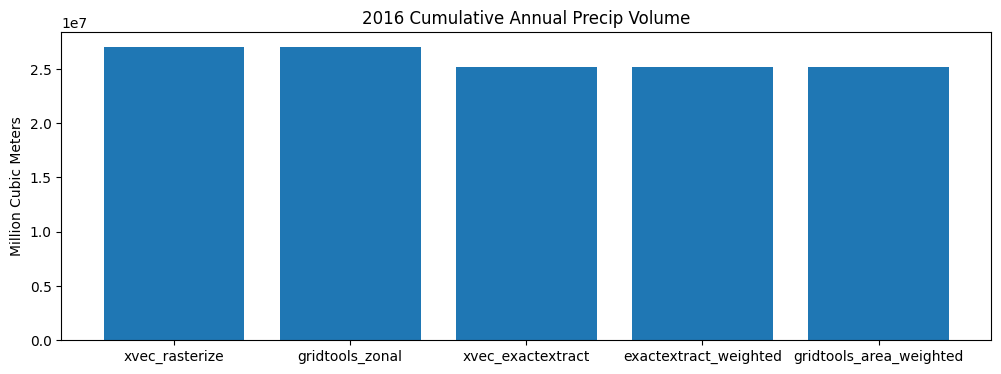

In [61]:
all_vols = np.array([rvol.sel(time=slice('2016-01-01', '2016-12-31')).sum().values,
                     gtrstr_vol['precipitation_amount'].sum(),
                     evol.sum().values,
                     out.iloc[0,:366].sum(),
                     gtaw_a.sum().values])
labs = ['xvec_rasterize',
        'gridtools_zonal',
        'xvec_exactextract',
        'exactextract_weighted',
        'gridtools_area_weighted']
fig = plt.figure(figsize=(12, 4))
ax = plt.axes()
ax.bar(np.arange(0, all_vols.size), all_vols, tick_label=labs)
ax.set_ylabel('Million Cubic Meters')
ax.set_title('2016 Cumulative Annual Precip Volume')

The results show that the GRIDtools methods are in-line with other zonal stats packages. Can also view at daily timesteps. They all overlap so colors aren't very distinguishable (which is good!). Main point is that the area weighted methods (GRIDtools and exactextract) return near identical daily values. The rasterize zonal values are higher than the area weighted values as expected, but consistent among the rasterize methods.

C:\Users\CNB968\AppData\Local\Temp\ipykernel_30260\951294033.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(rvol.sel(time=slice('2016-01-01', '2016-12-31'))['time'], rvol.sel(time=slice('2016-01-01', '2016-12-31')).cumsum().values[0,:], marker=None, ls='solid', alpha=0.35, label='xvec_rasterize')
C:\Users\CNB968\AppData\Local\Temp\ipykernel_30260\951294033.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(evol.sel(time=slice('2016-01-01', '2016-12-31'))['time'], evol.sel(time=slice('2016-01-01', '2016-12-31')).cumsum().values[0,:], marker=None, ls='solid', alpha=0.35, label='exactextract')
C:\Users\CNB968\AppData\Local\Temp\ipykernel_30260\951294033.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword ar

Text(0, 0.5, 'Million Cubic Meters')

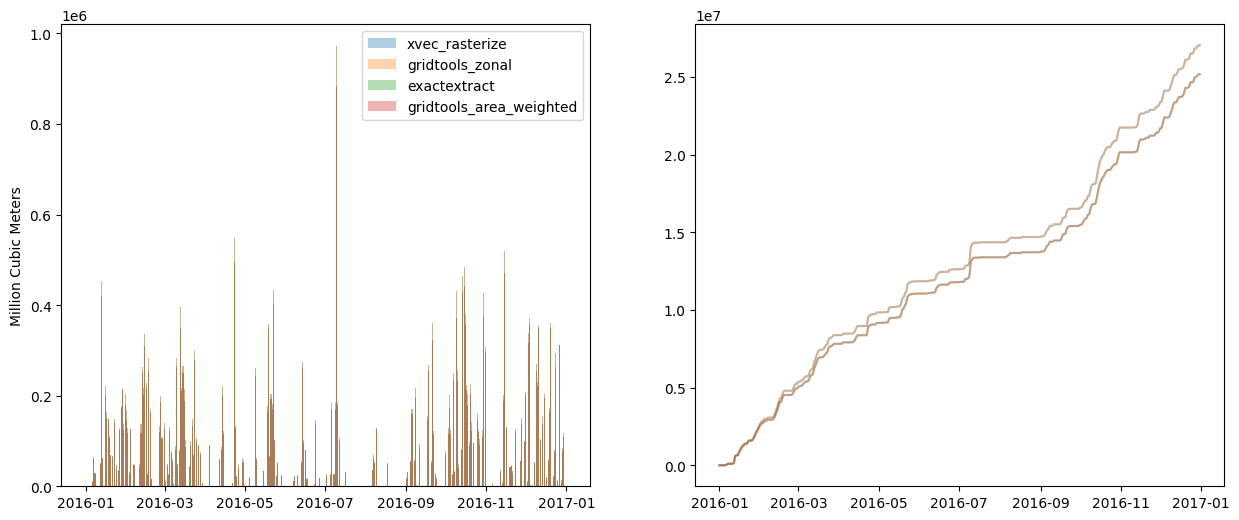

In [94]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.bar(rvol.sel(time=slice('2016-01-01', '2016-12-31'))['time'], rvol.sel(time=slice('2016-01-01', '2016-12-31')).values[0,:], alpha=0.35, label='xvec_rasterize')
ax2.plot_date(rvol.sel(time=slice('2016-01-01', '2016-12-31'))['time'], rvol.sel(time=slice('2016-01-01', '2016-12-31')).cumsum().values[0,:], marker=None, ls='solid', alpha=0.35, label='xvec_rasterize')
ax.bar(gtrstr_vol.loc[0, slice('2016-01-01', '2016-12-31'), 'mean'].index.get_level_values(level='time'),
       gtrstr_vol.loc[0, slice('2016-01-01', '2016-12-31'), 'mean']['precipitation_amount'],
       alpha=0.35,
       label='gridtools_zonal')
ax2.plot(gtrstr_vol.loc[0, slice('2016-01-01', '2016-12-31'), 'mean'].index.get_level_values(level='time'),
         gtrstr_vol.loc[0, slice('2016-01-01', '2016-12-31'), 'mean']['precipitation_amount'].cumsum(),
         marker=None,
         ls='solid',
         alpha=0.35,
         label='gridtools_zonal')
ax.bar(evol.sel(time=slice('2016-01-01', '2016-12-31'))['time'], evol.sel(time=slice('2016-01-01', '2016-12-31')).values[0,:], alpha=0.35, label='exactextract')
ax2.plot_date(evol.sel(time=slice('2016-01-01', '2016-12-31'))['time'], evol.sel(time=slice('2016-01-01', '2016-12-31')).cumsum().values[0,:], marker=None, ls='solid', alpha=0.35, label='exactextract')
ax.bar(gtaw_a.time, gtaw_a.values, alpha=0.35, label='gridtools_area_weighted')
ax2.plot_date(gtaw_a.time, gtaw_a.cumsum().values, marker=None, ls='solid', alpha=0.35, label='gridtools_area_weighted')
ax.legend()
ax.set_ylabel('Million Cubic Meters')


### Check the grid cells selected by exactextract.

Define a function to convert the flat zero based index that exactextract returns as a cell id.

In [31]:
def zero_to_nd_indexer(index, rows, cols):
    tracker = 0
    i = 0
    j = 0
    for i in range(0, rows):
        if i > 0:
            tracker += 1
        j=0
        while j < cols-1:
            if tracker == index:
                break
            j += 1
            tracker += 1
        
        if tracker == index:
            break      
    
    return (i, j)

Get the cell id using the 'cell_id' ops argument.

In [32]:
s_cells = exactextract.exact_extract(prcp_proj_s, geom_proj, ops='cell_id', output='pandas')

c:\Users\CNB968\.conda\envs\wmbflow\lib\site-packages\exactextract\exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(


In [47]:
# 1st geometry
ex1_rid = []
ex1_cid = []
for i in s_cells.iloc[0,0]:
    r, c = zero_to_nd_indexer(i, prcp_proj_s.precipitation_amount.shape[1], prcp_proj_s.precipitation_amount.shape[2])
    ex1_rid.append(r)
    ex1_cid.append(c)
ex1_r = np.array(ex1_rid)
ex1_c = np.array(ex1_cid)
# 2nd geometry
ex2_rid = []
ex2_cid = []
for i in s_cells.iloc[1,0]:
    r, c = zero_to_nd_indexer(i, prcp_proj_s.precipitation_amount.shape[1], prcp_proj_s.precipitation_amount.shape[2])
    ex2_rid.append(r)
    ex2_cid.append(c)
ex2_r = np.array(ex2_rid)
ex2_c = np.array(ex2_cid)

In [48]:
# mask for 1st geometry for plotting
msk1 = np.zeros((prcp_proj.precipitation_amount.shape[1], prcp_proj.precipitation_amount.shape[2]))
msk1[ex1_rid, ex1_cid] = 1
ex1_cells = prcp_proj.precipitation_amount[0,:,:]
ex1_cells['precipitation_amount'] = (['y', 'x'], msk1)
# mask for 2nd geometry for plotting
msk2 = np.zeros((prcp_proj.precipitation_amount.shape[1], prcp_proj.precipitation_amount.shape[2]))
msk2[ex2_rid, ex2_cid] = 1
ex2_cells = prcp_proj.precipitation_amount[0,:,:]
ex2_cells['precipitation_amount'] = (['y', 'x'], msk2)

The cell selection appears to accurately represent the geometries despite exactextract giving a user warning about mismatched coordinate references systems. The raster and geometry are both in epsg:5071

<Axes: title={'center': 'time = 2016-01-01, crs = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

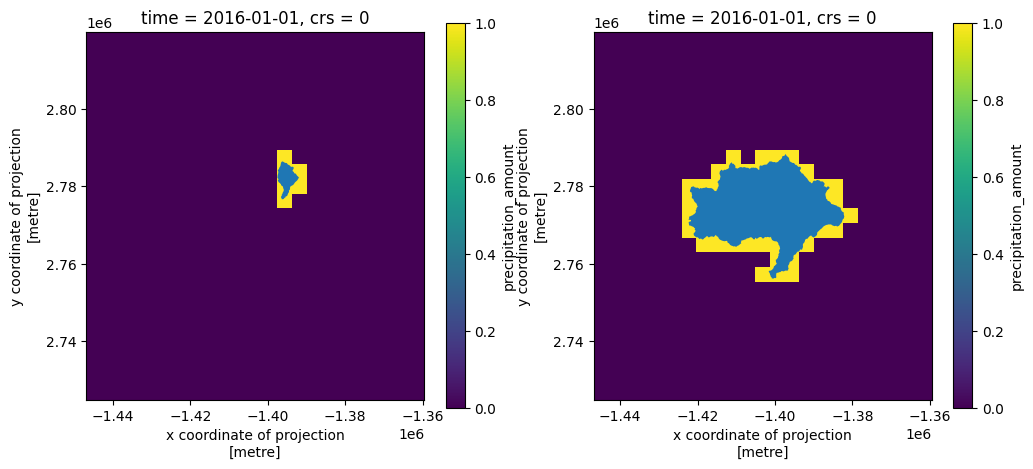

In [53]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ex1_cells.precipitation_amount.plot(ax=ax)
geom_proj.loc[[0]].plot(ax=ax)
ex2_cells.precipitation_amount.plot(ax=ax2)
geom_proj.loc[[1]].plot(ax=ax2)

## Test functions on many polygons and non-multidimensional elevation data

In [96]:
in_tif = r'D:\ArcGIS_Projects\Yellowstone\Upper Yellowstone\prms\MT_hydro_SRTM_30m_clipped.tif'
in_grid = r'D:\ArcGIS_Projects\Yellowstone\Upper Yellowstone\prms\UY_Voronoi_Grid.shp'

In [97]:
elev = gt.calc_zonal_stats(in_grid, in_tif, stats=['mean', 'count'], output='pandas')

C:\Users\CNB968\AppData\Local\Temp\ipykernel_30260\4016084799.py:1: UserWarning: Not all geometries were returned, 192 geometries were missed during rasterize. Attempting to rasterize missed geometries...
  elev = gt.calc_zonal_stats(in_grid, in_tif, stats=['mean', 'count'], output='pandas')


Second attempt did not return all geometries, defaulting to point locations for remaining geometries.


You can see the calc_zonal_stats function treats overlapping or sub-grid resolution polygons as points if all features are not rasterized in 2 attempts. This does ensure all polygons are returned.

In [102]:
elev.loc[slice(None), slice(None), 'single_point']

,,Value
FID,Band,
1154,1,2871.0
2960,1,2366.0
2976,1,2362.0
3007,1,2359.0
3009,1,2360.0
...,...,...
4836,1,2726.0
4840,1,2748.0
4850,1,1511.0


You can select out the geometries that defaulted to point locations by selecting where the 'stat' dimension of the index is equal to 'single_point.'

In [103]:
geom = gpd.read_file(in_grid)

This also means that you will need to pass the 'single_point' stat type with any other stat you want to select or the polygons that used a single point selection will not be included...

In [109]:
geom['elevation'] = elev.loc[slice(None), slice(None), ['mean', 'single_point']].values.ravel()

Text(0.5, 1.0, 'Elevation Mapped to Unstructured Grid Polygons')

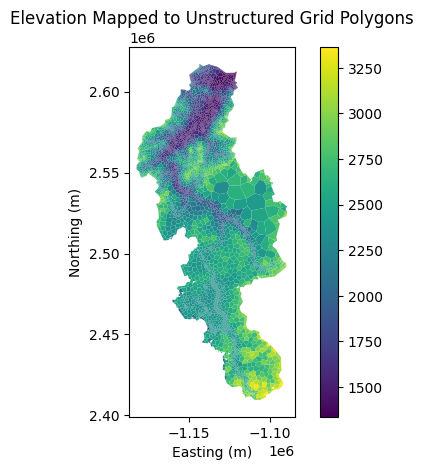

In [114]:
ax = plt.axes()
cl = geom.plot(column='elevation', ax=ax, legend=True)
ax.set_ylabel('Northing (m)')
ax.set_xlabel('Easting (m)')
ax.set_title('Elevation Mapped to Unstructured Grid Polygons')

In [120]:
print(f"Check if any mapped polygons are missing elevation values: {geom.isna()['elevation'].any()}")

Check if any mapped polygons are missing elevation values: False
